In [23]:
np.sum(1,2)

AxisError: axis 2 is out of bounds for array of dimension 0

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
# config: depends whether you're on Google Colab or local

# On google colab
# Mount GDrive and attach it to the colab for data I/O
# from google.colab import drive
# drive.mount('/content/drive')
# input_dir = '/content/drive/My Drive/covid19_argentina/data/input/'
# output_dir = '/content/drive/My Drive/covid19_argentina/data/output/'

# Locally
input_dir = './data/input/'
output_dir = './data/output/'



In [3]:
def add_top_column(df, top_col, inplace=True):
    if not inplace:
        df = df.copy()
    
    df.columns = pd.MultiIndex.from_product([[top_col], df.columns])
    return df

In [4]:
# Hyperparameter tuning

# Parameters of pipelines can be set using ‘__’ separated parameter names:

def lasso_standardscaler_alpha(X,y,cv=10):
    alphas= np.logspace(-4, 0, 30) #equally spaced on log scale from 10**-4 (0.0004) to 10**0 (1)
    pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler()), 
        ('model', Lasso())
    ])
    param_grid = {
        'model__alpha': alphas,
    }
    search = GridSearchCV(pipe,param_grid, cv=cv,n_jobs=-1)
    search.fit(X,y)
    results = pd.DataFrame(search.cv_results_)
    best = results[results['rank_test_score']==1]
    mean_score = best.mean_test_score.values
    std_score = best.std_test_score.values
    alpha = float(best.param_model__alpha.values)
    return alpha

In [5]:
# Load data

df = pd.read_csv(input_dir+'COVID-19_risk.csv', sep = ';')
df

,id,Region,Age_scale,Gender,MALE,FEMALE,Educational level,SES,VAC_STATUS,Contagion,Ideology,PHQ4_T,SANIT_PRES,SANIT_FUT,RESTRICC,PHB_INDEX,RISK_INDEX
0,3726,2,1,1,1,0,2,2,0,0,0,3,3,4,3,,7
1,10437,2,1,1,1,0,2,2,0,0,1,0,3,4,2,12,6
2,10940,2,1,2,0,1,3,2,0,0,1,7,3,4,3,11,7
3,11380,1,1,2,0,1,1,1,0,0,0,11,4,5,5,12,10
4,15855,1,1,2,0,1,1,1,0,1,0,,4,2,3,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,414511,2,4,1,1,0,1,,0,0,1,1,3,3,3,9,6
2890,430354,1,4,1,1,0,2,1,0,0,1,,4,,1,6,
2891,461092,1,4,1,1,0,3,3,0,0,1,0,3,4,5,10,8
2892,471159,1,4,2,0,1,1,,0,0,1,,3,,2,8,


In [6]:
df.columns

Index(['id', 'Region', 'Age_scale', 'Gender', 'MALE', 'FEMALE',
       'Educational level', 'SES', 'VAC_STATUS', 'Contagion', 'Ideology',
       'PHQ4_T', 'SANIT_PRES', 'SANIT_FUT', 'RESTRICC', 'PHB_INDEX',
       'RISK_INDEX'],
      dtype='object')

In [7]:
# with regards to the correlation, we added a few variables 
X = df[[
        'Region', 'Age_scale', 
#     'Gender', 'MALE', 
    'FEMALE',
       'Educational level', 'SES', 'VAC_STATUS', 'Contagion', 'Ideology',
       'PHQ4_T', 'SANIT_PRES', 'SANIT_FUT', 'RESTRICC', 'PHB_INDEX',
       'RISK_INDEX'
       ]]

# # Create dummy variable for gender
# gender = X['Gender']
# gender = pd.get_dummies(gender,prefix='Gender')
# print(gender)
# print(gender.sum())


# X = X.drop('Gender', axis=1)
# X['Gender_female'] = gender['Gender_1']
# X['Gender_male'] = gender['Gender_2']
# # other genders were not included since there were only 9. 

variables = X.columns.values
clean_names= dict(zip(
    variables,
#     variables
    ['Region', 'Age groups','Female (binary)','Education level','SES', 'Vaccinated','Past Covid19 diagnosis', 'Politically opposed', 'Emotional distress (PHQ4)', 'Perceived seriousness (current)','Perceived seriousness (future)','Attitude towards restrictions','Protective Health Behaviors','Personal Risk']
    
    ))

pd.DataFrame(clean_names, index=[0]).T


,0
Region,Region
Age_scale,Age groups
FEMALE,Female (binary)
Educational level,Education level
SES,SES
VAC_STATUS,Vaccinated
Contagion,Past Covid19 diagnosis
Ideology,Politically opposed
PHQ4_T,Emotional distress (PHQ4)
SANIT_PRES,Perceived seriousness (current)


In [8]:
X = X.replace(' ', -1)
X = X.astype(int)
X = X.replace(-1, np.nan)
X

,Region,Age_scale,FEMALE,Educational level,SES,VAC_STATUS,Contagion,Ideology,PHQ4_T,SANIT_PRES,SANIT_FUT,RESTRICC,PHB_INDEX,RISK_INDEX
0,2,1,0,2,2.0,0,0,0,3.0,3.0,4.0,3.0,NaN,7.0
1,2,1,0,2,2.0,0,0,1,0.0,3.0,4.0,2.0,12.0,6.0
2,2,1,1,3,2.0,0,0,1,7.0,3.0,4.0,3.0,11.0,7.0
3,1,1,1,1,1.0,0,0,0,11.0,4.0,5.0,5.0,12.0,10.0
4,1,1,1,1,1.0,0,1,0,NaN,4.0,2.0,3.0,12.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,2,4,0,1,NaN,0,0,1,1.0,3.0,3.0,3.0,9.0,6.0
2890,1,4,0,2,1.0,0,0,1,NaN,4.0,NaN,1.0,6.0,NaN
2891,1,4,0,3,3.0,0,0,1,0.0,3.0,4.0,5.0,10.0,8.0
2892,1,4,1,1,NaN,0,0,1,NaN,3.0,NaN,2.0,8.0,NaN


In [9]:
X.describe()

,Region,Age_scale,FEMALE,Educational level,SES,VAC_STATUS,Contagion,Ideology,PHQ4_T,SANIT_PRES,SANIT_FUT,RESTRICC,PHB_INDEX,RISK_INDEX
count,2894.000000,2894.000000,2894.000000,2894.000000,2601.000000,2894.000000,2894.000000,2894.000000,2454.000000,2688.000000,2677.000000,2814.000000,2824.000000,2362.000000
mean,1.697650,2.850380,0.575674,2.388390,2.162245,0.078438,0.066344,0.610919,3.090872,3.047619,3.854688,3.072139,10.894830,7.934801
std,0.459355,0.918417,0.494326,0.728524,0.771495,0.268906,0.248926,0.487626,3.060388,0.771155,1.018600,1.187139,1.493375,2.289319
min,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,3.000000
25%,1.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,2.000000,10.000000,6.000000
50%,2.000000,3.000000,1.000000,3.000000,2.000000,0.000000,0.000000,1.000000,2.000000,3.000000,4.000000,3.000000,11.000000,8.000000
75%,2.000000,4.000000,1.000000,3.000000,3.000000,0.000000,0.000000,1.000000,5.000000,4.000000,5.000000,4.000000,12.000000,10.000000
max,2.000000,4.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,12.000000,4.000000,5.000000,5.000000,12.000000,12.000000


In [10]:
X.corr(method='spearman')

,Region,Age_scale,FEMALE,Educational level,SES,VAC_STATUS,Contagion,Ideology,PHQ4_T,SANIT_PRES,SANIT_FUT,RESTRICC,PHB_INDEX,RISK_INDEX
Region,1.000000,-0.111440,-0.005001,0.050861,0.019657,-0.015018,0.057591,0.044064,-0.033845,-0.014786,-0.025615,-0.048041,-0.123620,-0.105752
Age_scale,-0.111440,1.000000,0.041495,-0.085473,0.018993,0.135439,-0.079830,0.055173,-0.031138,-0.019493,-0.099869,-0.021903,0.212779,0.131705
FEMALE,-0.005001,0.041495,1.000000,0.042024,0.002793,-0.014765,-0.021151,0.051924,0.119300,0.059181,0.002153,0.012738,0.104073,0.067361
Educational level,0.050861,-0.085473,0.042024,1.000000,0.792771,-0.000203,-0.014478,0.069594,-0.008232,-0.090726,0.048719,0.009216,-0.067433,-0.010828
SES,0.019657,0.018993,0.002793,0.792771,1.000000,0.028594,-0.014084,0.050626,-0.057275,-0.127849,0.026661,-0.005245,-0.086026,-0.020716
VAC_STATUS,-0.015018,0.135439,-0.014765,-0.000203,0.028594,1.000000,-0.005474,-0.038695,-0.048086,-0.014551,-0.059812,0.067167,0.110725,0.008261
Contagion,0.057591,-0.079830,-0.021151,-0.014478,-0.014084,-0.005474,1.000000,-0.009387,0.008603,-0.001092,0.000440,-0.005475,-0.047997,-0.039754
Ideology,0.044064,0.055173,0.051924,0.069594,0.050626,-0.038695,-0.009387,1.000000,0.063244,0.061889,0.104539,-0.287537,-0.114109,-0.137286
PHQ4_T,-0.033845,-0.031138,0.119300,-0.008232,-0.057275,-0.048086,0.008603,0.063244,1.000000,0.133230,0.146168,0.025380,-0.031114,0.238901
SANIT_PRES,-0.014786,-0.019493,0.059181,-0.090726,-0.127849,-0.014551,-0.001092,0.061889,0.133230,1.000000,0.376383,0.161294,0.175004,0.309539


/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentin

/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

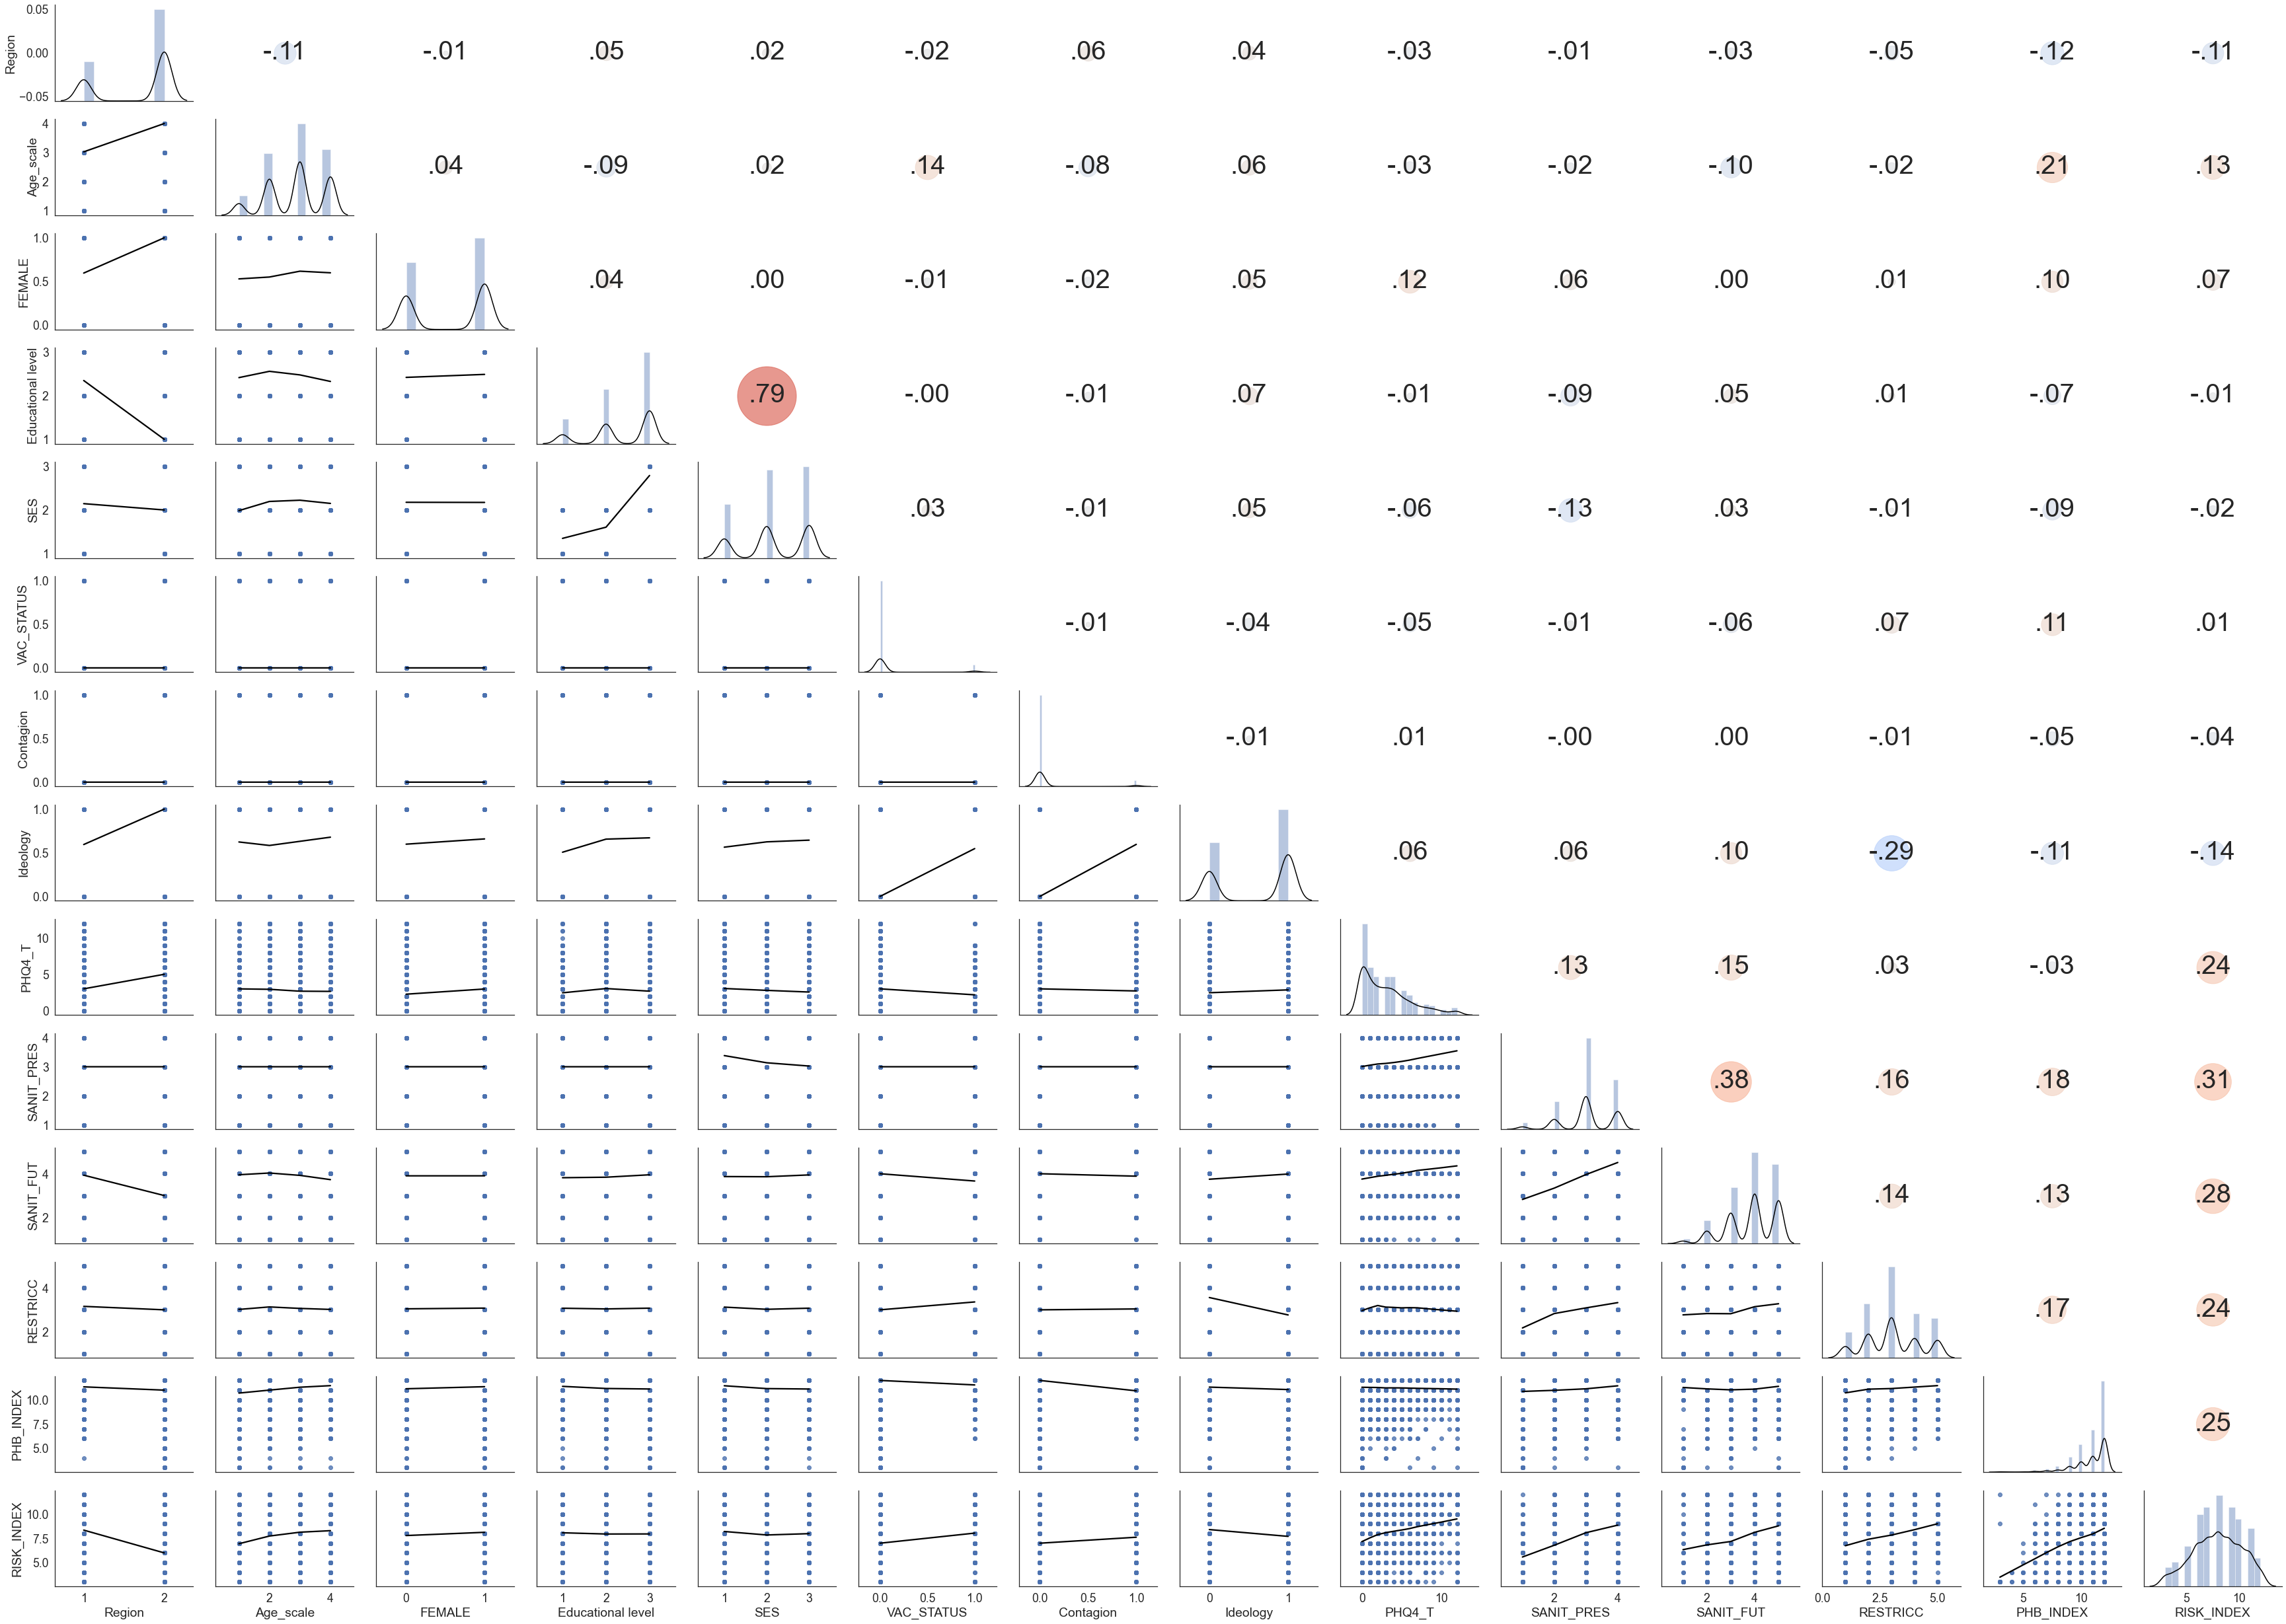

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
#     print(abs(corr_r) *10000)
    
    marker_size = abs(corr_r) * 10000
    
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = 40 #abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
# iris = sns.load_dataset('iris')
g = sns.PairGrid(X, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

In [12]:
# Create DFs for each IV

# Depression

dvs = ['RESTRICC', 'RISK_INDEX', 'PHB_INDEX'] #dependent variables

variable_names = {}
Xs = {}
ys = {}

for dv_i in dvs:
    variable_names[dv_i] = X.drop(dv_i,axis=1).columns.values
    Xs[dv_i] = X.drop(dv_i,axis=1).values
    ys[dv_i] = X[dv_i].values
    print(dv_i, 'covariates', variable_names.get(dv_i))
    print(    Xs.get(dv_i).shape,     ys.get(dv_i).shape)
    print('\n\n')


RESTRICC covariates ['Region' 'Age_scale' 'FEMALE' 'Educational level' 'SES' 'VAC_STATUS'
 'Contagion' 'Ideology' 'PHQ4_T' 'SANIT_PRES' 'SANIT_FUT' 'PHB_INDEX'
 'RISK_INDEX']
(2894, 13) (2894,)



RISK_INDEX covariates ['Region' 'Age_scale' 'FEMALE' 'Educational level' 'SES' 'VAC_STATUS'
 'Contagion' 'Ideology' 'PHQ4_T' 'SANIT_PRES' 'SANIT_FUT' 'RESTRICC'
 'PHB_INDEX']
(2894, 13) (2894,)



PHB_INDEX covariates ['Region' 'Age_scale' 'FEMALE' 'Educational level' 'SES' 'VAC_STATUS'
 'Contagion' 'Ideology' 'PHQ4_T' 'SANIT_PRES' 'SANIT_FUT' 'RESTRICC'
 'RISK_INDEX']
(2894, 13) (2894,)





In [13]:
# Train and test

coefs_all= []
r2_all=[]


for dv_i in dvs:
    print(dv_i)
    X_i = Xs.get(dv_i)
    y_i = ys.get(dv_i)
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    y_i = imp.fit_transform(y_i.reshape(-1, 1)) 
    
    variable_names_i = variable_names.get(dv_i)
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size=0.2, random_state=42)

    # Hyperparameter tuning     
    best_alpha = lasso_standardscaler_alpha(X_train,y_train,cv=10) # Find best alpha through CV
    print('best_alpha:',best_alpha)
#     best_alpha = 0.1
    
    # Train final model      
    pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler()), 
        ('model', Lasso(alpha = best_alpha))
    ])
    pipe.fit(X_train,y_train)
    
    # Test     
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    
    # Obtain standardized beta coefficients     
    coefs= pd.DataFrame(pipe['model'].coef_,index=variable_names_i, columns= ['Coefficient'])
    
    # Clean dataframe     
    coefs.index = [clean_names.get(n) for n in coefs.index.values]
    coefs['Abs. Coef.'] = coefs['Coefficient'].abs()
    coefs= coefs.sort_values('Abs. Coef.')[::-1].reset_index()
    coefs.index +=1
    coefs= coefs.reset_index().round(2)
    coefs.columns= ['Importance', 'Covariate', 'Coefficient','Abs. Coef.']
    coefs['Coefficient'] =     coefs['Coefficient'].astype(str).replace('^(-)0.|^0.',r'\1.',regex=True)
#     if dv_i == 'depression':
#         coefs= coefs.drop(['Abs. Coef.'], axis=1)#drop abs value
#     else:
    coefs= coefs.drop(['Abs. Coef.','Importance'], axis=1)#drop abs value
    
    coefs = add_top_column(coefs,f'{clean_names.get(dv_i).capitalize()} (R^2 = {np.round(r2,2)})' )
    coefs.to_csv(output_dir+f'coefs_{dv_i}.csv',index=False)
    coefs_all.append(coefs)
    r2_all.append([dv_i,np.round(r2,2)])



RESTRICC
best_alpha: 0.008531678524172805
RISK_INDEX
best_alpha: 0.01610262027560939
PHB_INDEX
best_alpha: 0.0032903445623126675


In [14]:
# Alternative that does not return best params
#     reg = LassoCV(cv=10,alphas = alphas,normalize=True, random_state=0).fit(X_train, y_train) #normalize
#     r2 = reg.score(X_test, y_test)

In [15]:
# Concatenate 3 dataframes
coefs_all_clean = pd.concat(coefs_all,axis=1)
coefs_all_clean.index+=1
coefs_all_clean = coefs_all_clean.rename_axis('Importance').reset_index()
coefs_all_clean.to_csv(output_dir+'coefs_all.csv', index=False)
coefs_all_clean

Importance Attitude towards restrictions (R^2 = 0.13)              \
                                               Covariate Coefficient   
0           1                        Politically opposed        -.31   
1           2                              Personal Risk         .15   
2           3                Protective Health Behaviors         .14   
3           4            Perceived seriousness (current)         .12   
4           5             Perceived seriousness (future)         .09   
5           6                                 Vaccinated         .07   
6           7                                 Age groups        -.06   
7           8                            Education level         .03   
8           9                  Emotional distress (PHQ4)        -.01   
9          10                                     Region        -.01   
10         11                            Female (binary)         -.0   
11         12                     Past Covid19 diagnosis          .0   
12         13                                        SES         -.0   

         Personal risk (R^2 = 0.18)              \
                          Covariate Coefficient   
0   Perceived seriousness (current)         .38   
1         Emotional distress (PHQ4)         .33   
2    Perceived seriousness (future)         .32   
3       Protective Health Behaviors         .27   
4               Politically opposed        -.26   
5                        Age groups         .25   
6     Attitude towards restrictions         .25   
7                            Region        -.04   
8            Past Covid19 diagnosis        -.04   
9                   Education level         .04   
10                  Female (binary)         .01   
11                       Vaccinated         -.0   
12                              SES          .0   

   Protective health behaviors (R^2 = 0.14)              
                                  Covariate Coefficient  
0                                Age groups         .29  
1                             Personal Risk         .21  
2           Perceived seriousness (current)         .21  
3             Attitude towards restrictions         .18  
4                           Female (binary)         .12  
5                                    Region        -.11  
6                 Emotional distress (PHQ4)        -.11  
7                       Politically opposed         -.1  
8            Perceived seriousness (future)         .09  
9                                Vaccinated         .08  
10                   Past Covid19 diagnosis        -.06  
11                          Education level        -.03  
12                                      SES         -.0

# Generalized additive models

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pygam
from pygam import LinearGAM, LogisticGAM, s,f, l, GAM
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
# reload(pygam)
# from google.colab import files

In [17]:
def scatter_plot(dv_i, variables, clean_names):
    print('vertical axis:', clean_names.get(dv_i))
    plt.rcParams['figure.figsize'] = (12,12)
    length= len(variables)        
    fig, axs = plt.subplots(3, 4)
    axs = np.array(axs).flatten()

    y = X[dv_i].values
    j = 0
    for i, ax in enumerate(axs):
        if i>=length:
            continue
        feature = variables[j]
        if feature == dv_i:
            continue
        x = X[feature].values
        ax.scatter(x, y, s =5, alpha=0.05)
        ax.set_title(label = clean_names.get(variables[j]),fontsize=12)
        j+=1

    fig.tight_layout() 
    filename = f"scatter_{clean_names.get(dv_i)}.png"
    plt.savefig(output_dir+filename, dpi=300)
    # files.download(filename) 
    plt.show()

In [18]:

def pygam_partial_dependence_plot(gam,dv_i, variables,remaining_variables, significance, clean_names):
    errors={}

    plt.rcParams['figure.figsize'] = (12,12)
    length= len(variables)
    fig, axs = plt.subplots(3, 4)
    axs = np.array(axs).flatten()
    y = X[dv_i].values
    # y_norm = 

    for i, ax in enumerate(axs):
        if i>=length:
            continue
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i,X=XX, width=.95) #first one is intercept,so we skip

        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi[:, 0], c='grey', ls='--')
        ax.plot(XX[:, i], confi[:, 1], c='grey', ls='--')
        ax.set_ylim([-1, 1])
        if dtypes.get(remaining_variables[i] )=='categorical':
            ax.set_xlim([-0.5, 1.5])
            ax.set_xticks([0, 1])
    #     ax.ylim()
        error =  confi[:, 1] -   confi[:, 0] 
        errors[remaining_variables[i]] = np.mean(error)/(np.max(pdep)-np.min(pdep))


        sig = significance.get(i)
        if sig < 0.001:
            sig_symbol = '***' 
        elif sig < 0.01:
            sig_symbol = '**' 
        elif sig < 0.05:
            sig_symbol = '*'         
        else:
            sig_symbol = ''         

#         ax.set_title(titles[j].replace('_',' '),fontsize=16)        

        ax.set_title(clean_names.get(remaining_variables[i])+sig_symbol,fontsize=12)
    # #     # scatter
    #     x = X[remaining_variables[i]].values
    #     ax.scatter(x, y, s =5, alpha=0.1)


    fig.tight_layout() 
    filename = f"gam_{clean_names.get(dv_i)}.png"
    plt.savefig(output_dir+filename, dpi=300)
    # files.download(filename) 
    plt.show()

In [19]:
variables

array(['Region', 'Age_scale', 'FEMALE', 'Educational level', 'SES',
       'VAC_STATUS', 'Contagion', 'Ideology', 'PHQ4_T', 'SANIT_PRES',
       'SANIT_FUT', 'RESTRICC', 'PHB_INDEX', 'RISK_INDEX'], dtype=object)

In [20]:
# Specificy variable type
dtypes = {}
for i in variables:
    dtypes[i] = 'numerical'

dtypes['Region'] = 'categorical'
dtypes['FEMALE'] = 'categorical'
dtypes['VAC_STATUS'] = 'categorical'
dtypes['Contagion'] = 'categorical'
dtypes['Ideology'] = 'categorical'
dtypes_list = [dtypes.get(n) for n in variables]

dtypes = dict(zip(variables, dtypes_list))
dtypes

{'Region': 'categorical',
 'Age_scale': 'numerical',
 'FEMALE': 'categorical',
 'Educational level': 'numerical',
 'SES': 'numerical',
 'VAC_STATUS': 'categorical',
 'Contagion': 'categorical',
 'Ideology': 'categorical',
 'PHQ4_T': 'numerical',
 'SANIT_PRES': 'numerical',
 'SANIT_FUT': 'numerical',
 'RESTRICC': 'numerical',
 'PHB_INDEX': 'numerical',
 'RISK_INDEX': 'numerical'}

In [21]:
dtypes_df = pd.DataFrame([variables, dtypes_list]).T

vertical axis: Attitude towards restrictions


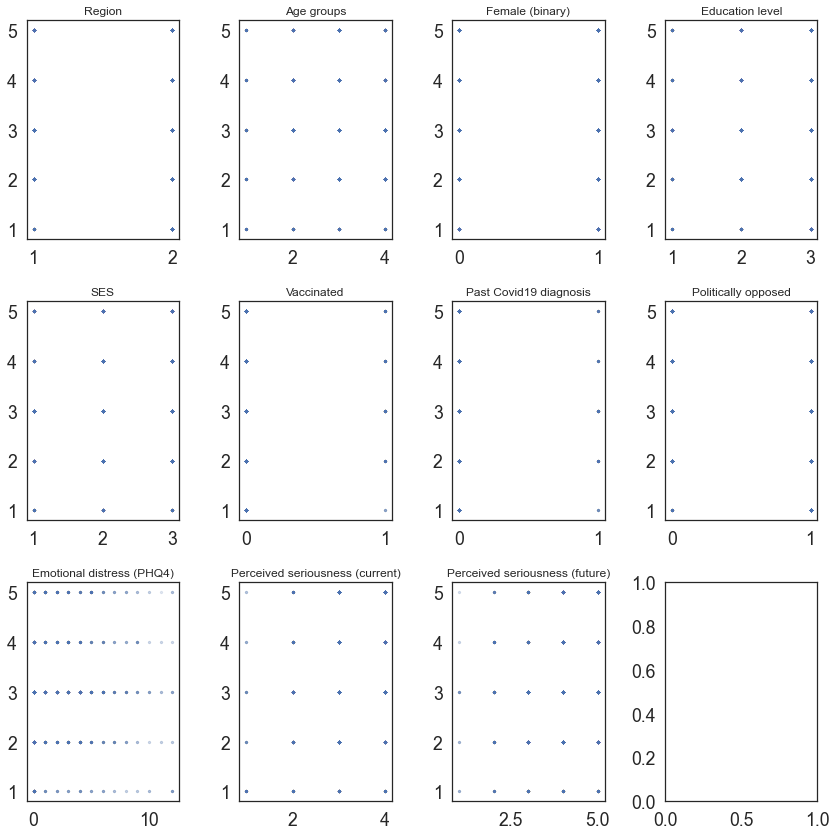

NameError: name 'cat' is not defined

In [22]:

scaler = MinMaxScaler(feature_range=(0, 1)) #categorical variables need to be [0,1] for pygam
imp = SimpleImputer(missing_values=np.nan, strategy='median')
# Run gridsearch over smoothing params


for dv_i in dvs:
    scatter_plot(dv_i, variables, clean_names)
    
    remaining_variables = X.drop(dv_i, axis=1).columns
    X[cat] = scaler.fit_transform(X[cat].values)
    X_i = X.drop(dv_i, axis=1).values
    X_i = imp.fit_transform(X_i) 
    y_i = X[dv_i].values
    y_i = imp.fit_transform(y_i.reshape(-1, 1)) 






    X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size=0.20, random_state=42)

    dtypes_list = [dtypes.get(n) for n in remaining_variables]
    
    
    # Fit GAM using gridsearch     
    gam = GAM(f(0) + s(1) + f(2) + s(3) + s(4) + f(5) +f(6) + f(7) + s(8) + s(9) + s(10) + s(11) + s(12),
          distribution = 'normal',
                          verbose=True,
               ).gridsearch(X_train, y_train,                            
                            lam=np.logspace(-3, 3, 11),
                            n_splines=[10,30,50,70]
                            # return_scores=True,
                            )# The gridsearch()function creates a grid to search over smoothing parameters.
    
    # Fully linear
    # gam = GAM(l(0) + l(1) + l(2) + l(3) + l(4) + l(5) +l(6) + l(7) + l(8) + l(9) + l(10) + l(11) + l(12),          
    #           distribution = 'normal',
    #                           verbose=True,
    #                ).gridsearch(X_train, y_train,
    #                             )
    
    print(gam)
    print(gam.summary())

    
    print('train performance')
    y_pred = gam.predict(X_train)
    rmse = sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R^2: {r2}")



    print('\n\ntest performance')
    y_pred = gam.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R^2: {r2}")

    p_values = gam.statistics_.get('p_values')
    #https://github.com/dswah/pyGAM/issues/197

    significance= dict(zip(list(range(17)), p_values[:-1])) #last one is intercept
    pygam_partial_dependence_plot(gam,dv_i, variables,remaining_variables, significance, clean_names)

In [ ]:
# Example of errors for single varia
errors

In [ ]:
pd.DataFrame(errors, index=['mean_error']).T.sort_values('mean_error').round(2)

# LASSO stats

In [ ]:
# !pip install statsmodels
# !pip install cvxopt

In [ ]:
# from statsmodels.regression.linear_model import OLSResults
# from statsmodels.regression.linear_model import OLS
# model = OLS(y_train,X_train)
# results = model.fit_regularized(method = 'elastic_net', alpha = 0.01, L1_wt=1, refit=True) #L1_wt=1 is LASSO, L1_wt=0 is Ridge
# # final = OLSResults(model, 
# #                                               results.params, 
# #                                               model.normalized_cov_params)

# # print(results.params)
# print(results.summary())


# # X_train = sm.add_constant(X_train)
# # model = sm.OLS(y_train, X_train)


